In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, f1_score
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
import os

## EfficientNetB0


In [3]:
TEST_DIR = 'cleaned_data/ISIC_2019_Training_Input_cleaned'
IMG_SIZE = (224, 224)
data = pd.read_csv("cleaned_data\\combined_GT_MD.csv")
class_cols = ['MEL', 'NV', 'BCC', 'BKL', 'other']


In [4]:
data['label'] = data[class_cols].idxmax(axis=1)
label_map = {name: idx for idx, name in enumerate(class_cols)}
data['label'] = data['label'].map(label_map)


In [5]:
meta_cols = [c for c in data.columns if c not in ['image', 'label', 'split', 'lesion_id'] + class_cols]

def load_images(image_ids, folder):
    images = []
    for image_id in image_ids:
        path = os.path.join(folder, image_id + '.jpg')
        img = cv2.imread(path)
        if img is None:
            print(f"Warning: image {path} not found or can't be read.")
            continue
        img = cv2.resize(img, IMG_SIZE)
        img = img.astype(np.float32) / 255.0
        images.append(img)
    return np.array(images)

In [6]:
test_df = data[data['split'] == 'test']
X_test_img = load_images(test_df['image'], TEST_DIR)
X_test_meta = test_df[meta_cols].values.astype('float32')
y_test = to_categorical(test_df['label'], num_classes=5)

In [7]:
model = load_model('cnn_before.keras')  


In [8]:
y_pred = model.predict([X_test_img, X_test_meta])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)


106/106 ━━━━━━━━━━━━━━━━━━━━ 41s 349ms/step


In [9]:
# Accuracy
test_loss, test_acc = model.evaluate([X_test_img, X_test_meta], y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.6610


In [10]:
print("\nRecall (Sensitivity) per class:")
recalls = recall_score(y_true_classes, y_pred_classes, average=None)
for cls, rec in zip(class_cols, recalls):
    print(f"{cls}: {rec:.4f}")


Recall (Sensitivity) per class:
MEL: 0.4341
NV: 0.8761
BCC: 0.7965
BKL: 0.4346
other: 0.1168


In [11]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_cols))



Classification Report:
              precision    recall  f1-score   support

         MEL       0.59      0.43      0.50       546
          NV       0.81      0.88      0.84      1622
         BCC       0.49      0.80      0.61       457
         BKL       0.43      0.43      0.43       382
       other       0.51      0.12      0.19       368

    accuracy                           0.66      3375
   macro avg       0.56      0.53      0.51      3375
weighted avg       0.65      0.66      0.64      3375



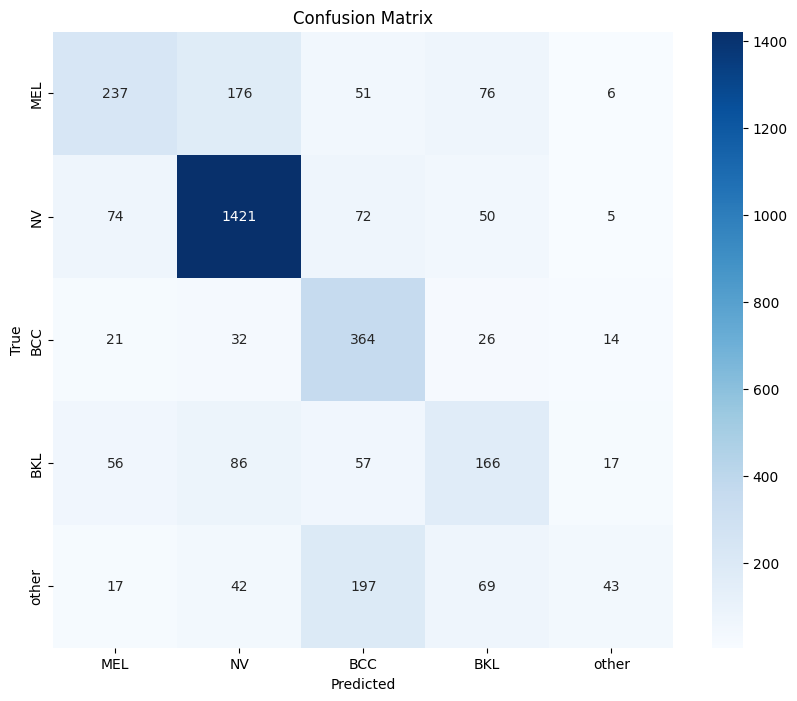

In [12]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_cols, yticklabels=class_cols)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

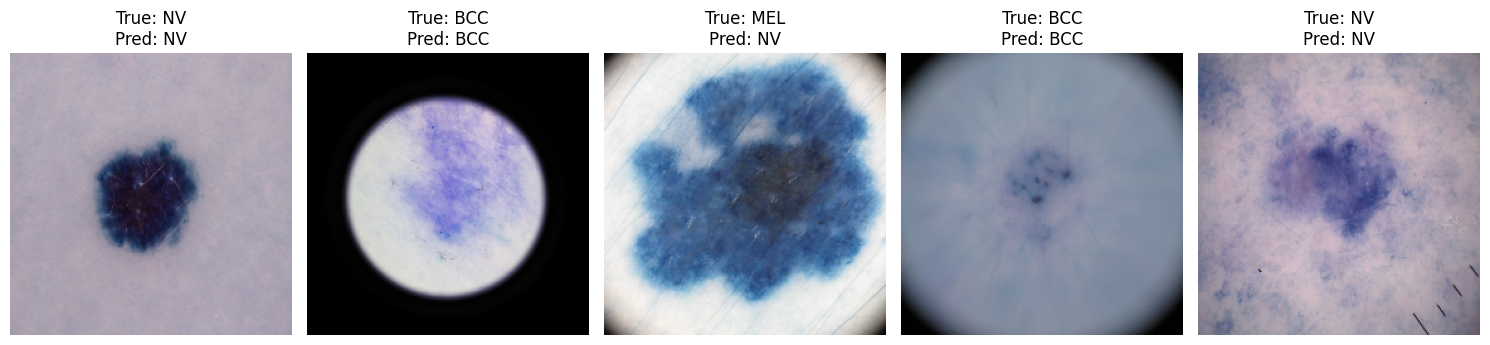

In [22]:
def plot_sample_predictions(images, true_labels, pred_labels, class_names, n=5):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        idx = np.random.randint(0, len(images))
        plt.subplot(1, n, i+1)
        plt.imshow(images[idx])
        plt.title(f"True: {class_names[true_labels[idx]]}\nPred: {class_names[pred_labels[idx]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_sample_predictions(X_test_img, y_true_classes, y_pred_classes, class_cols)

## CNN without metadata

In [ ]:
model1 = tf.keras.models.load_model('best_model.h5') 

In [15]:
y_pred1 = model1.predict([X_test_img, X_test_meta]) 
y_pred_classes1 = np.argmax(y_pred1, axis=1)
y_test_classes1 = np.argmax(y_test, axis=1)

106/106 ━━━━━━━━━━━━━━━━━━━━ 34s 288ms/step


In [19]:
print("Classification Report:")
print(classification_report(y_test_classes1, y_pred_classes1, target_names=class_cols))



Classification Report:
              precision    recall  f1-score   support

         MEL       0.22      0.07      0.11       546
          NV       0.63      0.93      0.75      1622
         BCC       0.28      0.41      0.33       457
         BKL       0.22      0.08      0.12       382
       other       0.00      0.00      0.00       368

    accuracy                           0.52      3375
   macro avg       0.27      0.30      0.26      3375
weighted avg       0.40      0.52      0.44      3375



c:\Users\talic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\talic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\talic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

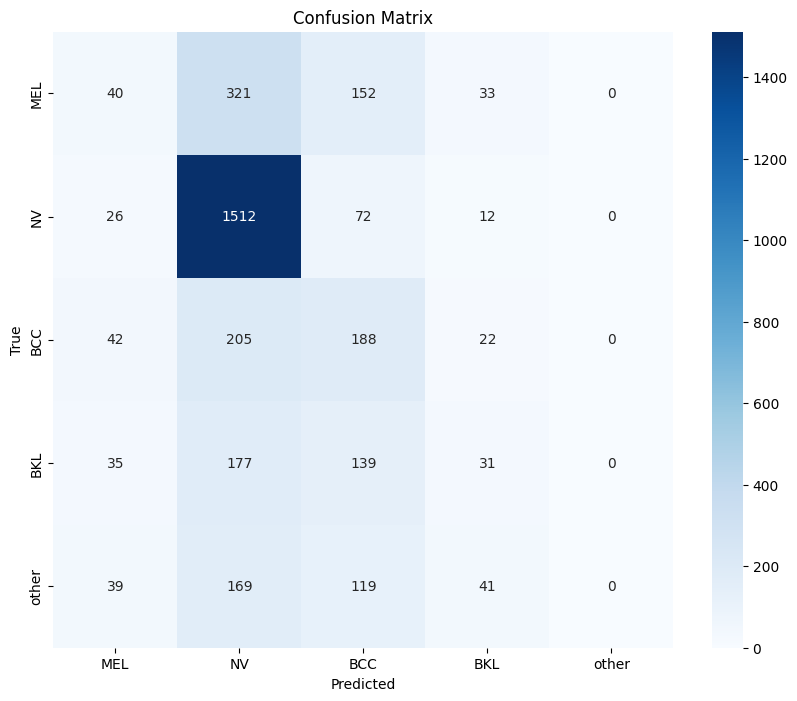

In [21]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_classes1, y_pred_classes1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_cols,
            yticklabels=class_cols)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()